## Selective Classification Can Magnify Disparities Across Groups


### AM207: Advanced Scientific Computing

#### Team: Jamelle Watson-Daniels, Shirley Wang, Bridger Ruyle, Paul Tembo

#### Paper: https://arxiv.org/pdf/2010.14134.pdfODOS: 

Minimal goal: Investigate how selective classification affects group accuracy on the `CelebA` dataset
- Generate synthetic dataset from `mnist`
- Train empirical risk minimization model (minimize loss - Logistic regression i.e. ResNet)    
- Calculate average coverage
- Calculate group coverage
- Calculate selective accuracy
- Plot average coverage vs group coverage for `CelebA` dataset
- Plot average coverage vs selective accuracy for `CelebA` dataset

If there is time goal: Show that selective accuracies on average and on the worst-group are determined by their respective margin distributions
- Calculate margin
- Calculate worst-group density
- Calculate Average density
- Plot margin (-10,+10) versus worst-group density
- Plot margin (-10,+10) versus Average density

Possible extensions: What are the characteristics of this dataset that are imbalanced and contain spurious correlations? We see that in all these datasets, the "worst group" is underrepresented as in there are much fewer examples for the "worst group" category. Notice that the datasets considered in this paper do not seem immediately relevant in terms of the real world implications of disparities, we wonder how we might examine this using toy examples.

#### Dataset description
"Models have been shown to latch onto spurious correlations between labels and demographic attributes such as race and gender (Buolamwini & Gebru, 2018; Joshi et al., 2018), and we
study this on the CelebA dataset (Liu et al., 2015). Following Sagawa et al. (2020), we consider
the task of classifying hair color, which is spuriously correlated with the gender. Concretely, inputs
are celebrity face images, labels are hair color Y = {blond, non-blond}, and spurious attributes are
gender, A = {male, female}, with blondness associated with being female. Of the four groups,
blond males are the smallest group, with only 1,387 examples out of 162,770 training examples, and
they tend to be the worst group empirically. We use the official train-val-split of the dataset."

In [1]:
import zipfile
import gdown
from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
import random
import torch
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import os

ModuleNotFoundError: No module named 'gdown'

In [ ]:
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with individual images
img_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'
# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(img_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(img_folder)


Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:10<00:00, 139MB/s]


In [ ]:
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

In [ ]:
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(f'{img_folder}/img_align_celeba', transform)

In [ ]:
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


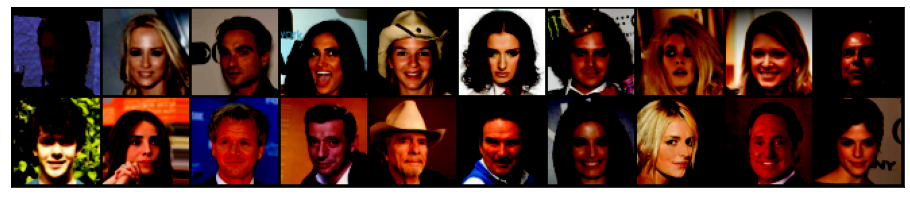

In [ ]:
for images in celeba_dataloader:
#for image, _ in celeba_dataloader:
  fig, ax = plt.subplots(figsize = (16,10))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(vutils.make_grid(images[:20],10).permute(1,2,0))
  break

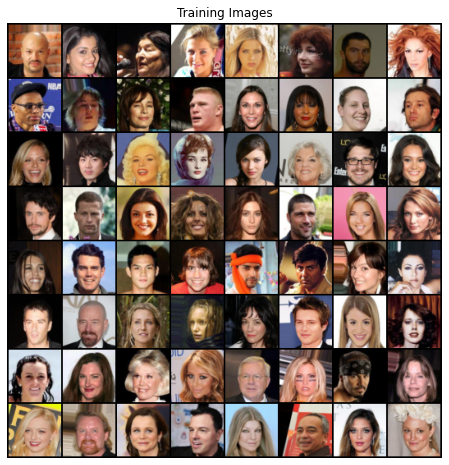

In [ ]:
real_batch = next(iter(celeba_dataloader))
image_grid = vutils.make_grid(real_batch.to(device)[:64],
                              padding=2,
                              normalize=True).cpu()
image_grid = np.transpose(image_grid, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(image_grid)

In [ ]:
# Read in the qualitative data
list_attr_celeba = pd.read_csv('list_attr_celeba.csv')
liss_attr_celeba_with_preds = pd.read_csv('list_attr_celeba_with_preds.csv')
list_bbox_celeba = pd.read_csv('list_bbox_celeba.csv')
list_eval_partition = pd.read_csv('list_eval_partition.csv')
list_landmarks_align_celeba = pd.read_csv('list_landmarks_align_celeba.csv')

FileNotFoundError: ignored

In [ ]:
list_attr_celeba.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
df_attributes = list_attr_celeba.copy()

df_attributes.set_index('image_id', inplace=True)
df_attributes.replace(to_replace=-1, value=0, inplace=True)

df_attributes.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
df_attributes.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,0.111136,0.266981,0.512505,0.204572,0.022443,0.151575,0.240796,0.234532,0.239251,0.147992,0.050899,0.205194,0.142168,0.057567,0.046688,0.065119,0.062764,0.041950,0.386922,0.455032,0.416754,0.483428,0.041545,0.115149,0.834940,0.284143,0.042947,0.277445,0.079778,0.065721,0.056511,0.48208,0.208402,0.319567,0.188925,0.048460,0.472436,0.122967,0.072715,0.773617
std,0.314301,0.442383,0.499845,0.403389,0.148121,0.358610,0.427568,0.423707,0.426627,0.355093,0.219791,0.403844,0.349223,0.232923,0.210971,0.246736,0.242539,0.200475,0.487047,0.497975,0.493023,0.499727,0.199548,0.319202,0.371236,0.451006,0.202738,0.447739,0.270950,0.247794,0.230906,0.49968,0.406167,0.466310,0.391450,0.214737,0.499241,0.328400,0.259669,0.418491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Check attributes
for i, j in enumerate(df_attributes.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


In [ ]:
#the prediciton task is hair color, the spurious attribute is gender. The worst group is blond men

training_sample = 10000
test_sample = 2000

#train Dataset
df_train = df_attributes.sample(training_sample)

Xsq_train_resample = df_train.loc[:, df_train.columns != 'Blond_Hair']
ysq_train = df_train.loc[:, df_train.columns == 'Blond_Hair']

# Test Dataset
df_test = df_attributes.sample(test_sample)

columns_exclude = ['Blond_Hair','Male']
select = [x for x in df_test.columns if x not in columns_exclude]
Xsq_test_resample = df_test.loc[:, select]

ysq_test = df_test.loc[:, df_train.columns == 'Blond_Hair']

In [ ]:
# starting to write class but cannot figure out how to access the images in integrated celebA dataset 
# from https://github.com/ejones313/worst-group-sc/blob/main/src/data/celebA_dataset.py

class CelebADataset(CelebA):
    def __init__(self, args):
        super().__init__(args):
        self.dataset_name = 'CelebA'
        self.data_dir = args.data_dir
        self.target_name = args.target_name
        self.confounder_names = args.confounder_names

        self.features_mat = None
        self.train_transform = get_transform_celebA(self.model)
        self.eval_transform = get_transform_celebA(self.model)

    def get_transform_celebA(model):
        orig_w = 178
        orig_h = 218
        orig_min_dim = min(orig_w, orig_h)
        if model_attributes[model]['target_resolution'] is not None:
            target_resolution = model_attributes[model]['target_resolution']
        else:
            target_resolution = (orig_w, orig_h)
        
        assert target_resolution is not None
        prelim_celebA_transforms = [transforms.CenterCrop(orig_min_dim), transforms.Resize(target_resolution)]
        tensor_celebA_transforms = [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
        transform_list = prelim_celebA_transforms + tensor_celebA_transforms
        transform = transforms.Compose(transform_list)
        return transform

SyntaxError: ignored

In [ ]:
## Look at github --> src/data/celebA_dataset.py

# transformed_celebA = CelebADataset(/datasets/CelebA) # can't debug this bc can't figure out how to access data

nx = 64 ##?? I believe these should be equal to the number of pixels (maybe transformed_celebA[0]?)
ny = 64 ##?? I believe these should be equal to the number of pixels (maybe transformed_celebA[1]?)
inputs = tf.keras.Input(shape = (nx, ny, 3))

In [ ]:
# Load ResNet with preset weights from "imagenet" training
base_model = tf.keras.applications.ResNet50(
    input_tensor = inputs,
    include_top = False,
    weights = 'imagenet'
)
base_model.traninable = False

In [ ]:
# Examine architecture of ResNet
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
# Add three layers at the end of ResNet:
    #A global average 2d pooling layer
    #A dropout layer
    #And a trainable binary classifier that predicts whether an celebrity has blond or non-blond hair
add_model = tf.keras.Sequential()
add_model.add(base_model)
add_model.add(tf.keras.layers.GlobalAveragePooling2D())
add_model.add(tf.keras.layers.Dropout(0.2))
add_model.add(tf.keras.layers.Dense(2, 
                    activation='softmax'))

model = add_model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
# Examine architecture of the full model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
Xsq_test_resample.shape

(2000, 38)

## Continue from here not sure what the issue is

In [ ]:
model.fit(X_train_data, y_train,
          epochs=100,
          verbose=1,
          validation_data=(X_validation, y_validation))

Epoch 1/100


ValueError: in user code:

    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, 100, 64, 3), found shape=(None, 39)


### Calculate average coverage, group coverage, selective accuracy


Average coverage = fraction of predicted points

In [ ]:
X = X_test ##all images
prediction = model.predict(X_test)
confidence = [0.5 * np.log10(p / (1 - p)) for p in prediction]

### Plot (1) average coverage vs group coverage and (2) average coverage vs selective accuracy

In [ ]:
list(df_attributes)

NameError: ignored

In [ ]:
worst_group_index = (df_attributes.Blond_Hair == 1) & (df_attributes.Male == 1)

In [ ]:
fig, ax = plt.subplots()
ax.hist(confidence, label = 'All data')
ax.hist(np.array(confidence)[worst_group_index], label = 'Worst group')
ax.set_title('Confidence')
ax.legend()

Idea: See what happens when we train model to have the best margin distribution for the previously identified "worst" group. For CelebA, the prediciton task is hair color, the spurious attribute is gender. The worst group is blond men

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive
